In [ ]:
%cd ../../../

In [2]:
import os
import torch
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

import smart_settings

from mbrl import allogger
from mbrl.models import forward_model_from_string
from mbrl.environments import env_from_string
from mbrl import torch_helpers
from mbrl.controllers.abstract_controller import OpenLoopPolicy
from mbrl.rolloutbuffer import RolloutBuffer
from mbrl.rolloutbuffer import SimpleRolloutBuffer 


device = torch.device("cuda:0")
torch_helpers.device = device


In [3]:
params = smart_settings.load(os.path.join('experiments/cee_us/settings/playground/common/playground_env.yaml'), make_immutable=False)
params['env_params']['seed'] = 65865
env = env_from_string(params.env, **params["env_params"])

In [4]:
def load_model(path, checkpoint_suffix, env):
    params = smart_settings.load(os.path.join(path, 'settings.json'), make_immutable=False)
    forward_model = forward_model_from_string(params.forward_model)(
            env=env, **params.forward_model_params
        )
    forward_model.load(os.path.join(path, 'checkpoints' + checkpoint_suffix, 'forward_model'))
    print("Loading model!")
    return forward_model

In [5]:
model_path = "results/cee_us/playground/gnn_ensemble_cee_us_freeplay"
params = smart_settings.load(os.path.join(model_path,'settings.json'), make_immutable=False)
params['working_dir'] = '/tmp/test'

In [6]:
allogger.basic_configure(logdir=params.working_dir, default_outputs=['hdf'],
                         hdf_writer_params=dict(min_time_diff_btw_disc_writes=1))

In [7]:
gnn_model = load_model(
    model_path,
    "_latest",
    env
)

Loading model!


In [8]:
initial_obs = env.reset()

In [9]:
env.set_state_from_observation(initial_obs)

## Render environment:

In [11]:
## RUN THE FOLLOWING ONLY IF YOU DIDN'T UNSET LD_PRELOAD!

# from mujoco_py import GlfwContext
# GlfwContext(offscreen=True)

### Move target site away

In [14]:
# Move target away:
mo_idx = env.model.body_name2id('target')
env.model.body_pos[mo_idx][:2] = [ 10, 10]
env.sim.forward()


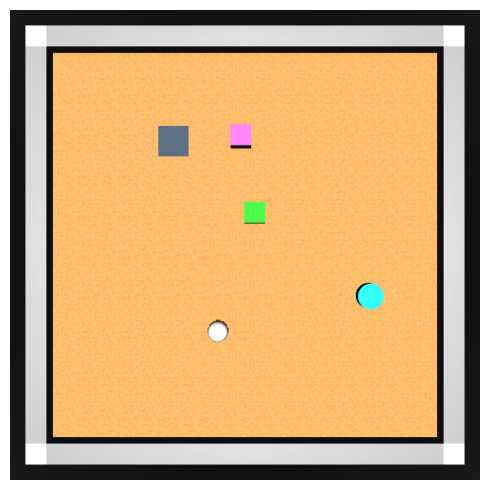

In [15]:
env_img = env.render(mode="rgb_array", render_width=1000, render_height=1000, camera_name="fixed")

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(env_img[40:-40, 40:-40])
ax.axis('off')
fig.tight_layout()


## Generate random actions on the unit circle:

In [16]:
num_actions = 8
phi = np.asarray([2*np.pi/num_actions * i for i in range(0,num_actions)])
unit_circle_actions = np.stack([np.sin(phi), np.cos(phi)], axis=1)

## Evaluate function to make next step predictions:

In [18]:
def evaluate(obs, action, model):
    if obs.ndim == 1 and action.ndim == 1:
        obs = obs[None,...]
        action = action[None,None,...] # assuming horizon is 1
    elif obs.ndim == 1 and action.ndim == 2:
        obs = np.tile(obs, (action.shape[0], 1))
        action = action[:,None,:]
    start_obs = torch.from_numpy(obs).float().to(device)
    action_sequence = torch.from_numpy(action).float().to(device)
    with torch.no_grad():
        policy = OpenLoopPolicy(action_sequence)
        out = model.predict_n_steps(start_observations=start_obs, start_states=None, policy=policy, horizon=1)[0]

    return out

# Get epistemic uncertainty heatmaps with GNN ensemble

### Specify for which checkpoint!

In [21]:
checkpoint_name = "_249"

In [22]:
playground_boundary = env.playground_size + 0.2

nx, ny = (0.01, 0.01) # Discretization step size!

x = np.arange(-playground_boundary, playground_boundary+nx, nx)

y = np.flip(np.arange(-playground_boundary, playground_boundary+nx, ny))

xv, yv = np.meshgrid(x, y)

uncertainties = []
gnn_model = load_model(
    model_path,
    checkpoint_name,
    env
)
for id_m,(x,y) in enumerate(zip(xv.flatten(),yv.flatten())):
    new_obs = initial_obs.copy()
    new_obs[0] = x 
    new_obs[1] = y

    out = evaluate(new_obs, unit_circle_actions, gnn_model)
    ensemble_disagreement_all_dims = np.std(out['next_observations'].squeeze(-2).cpu().detach().numpy(), axis=1)
    ensemble_disagreement_for_each_action = np.sum(ensemble_disagreement_all_dims, -1)
    uncertainties.append(np.mean(ensemble_disagreement_for_each_action))

uncertainty_map = np.reshape(np.asarray(uncertainties), xv.shape)

Loading model!


In [48]:
fig_path = ""
save_fig = False

In [49]:
plt.style.use('experiments/cee_us/hooks/post_rollout_hooks/prettyplots.mplstyle')
colors = [(0.368, 0.507, 0.71), (0.881, 0.611, 0.142), (0.923, 0.386,0.209),
          (0.56, 0.692, 0.195),(0.528, 0.471, 0.701), (0.772, 0.432,0.102),
          (0.572, 0.586, 0.) ]

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter

cmap = LinearSegmentedColormap.from_list("", [(1., 1., 1.),colors[1],colors[2]])

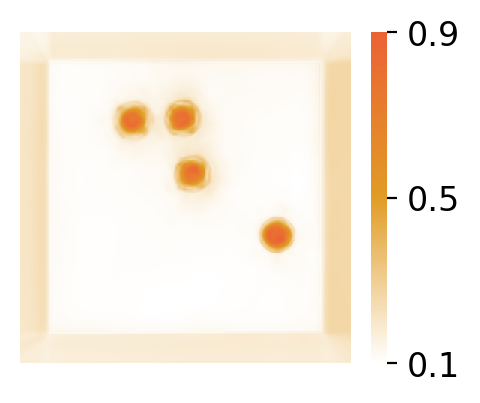

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

min_lim = np.min(uncertainty_map) 
max_lim = np.max(uncertainty_map) 
cbar_ticks = dict(ticks=[min_lim,
                     (min_lim+max_lim)/2,
                     max_lim]) 

sns.heatmap(uncertainty_map,
            ax=ax,
            cbar=True,
            square=True,
            xticklabels=False,
            yticklabels=False,
            linewidths=0.0, rasterized=True,
            vmin=min_lim, vmax=max_lim,
            cmap = cmap,
            cbar_kws = cbar_ticks,
           cbar_ax = cax,)

cax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.tight_layout()

if save_fig:
    fig.savefig(os.path.join(fig_path, f"epistemic_uncertainty_heatmap_cpt{checkpoint_name}.png"), dpi=300)
    # fig.savefig(os.path.join(fig_path, f"epistemic_uncertainty_heatmap_cpt{checkpoint_name}.svg"))


In [53]:
chosen_object = 3
# 0: Cube green (heavy cube)
# 1: Cube pink  (light cube)
# 2: Cylinder
# 3: Pyramid

In [54]:
obj_grid = int(0.4 / 0.01)
center = np.array([221, 221])

obs_dict = env.get_object_centric_obs(initial_obs)
obj_pos = obs_dict['objects_dyn'][chosen_object].flatten()[:2]

# Invert y position of object (because of the grid y axis): 
obj_pos[1] = (-1) * obj_pos[-1]

obj_center_in_grid = (center + np.ceil(obj_pos/0.01)).astype(int)

object_crop = uncertainty_map.copy()
object_crop = object_crop[obj_center_in_grid[1]-obj_grid:obj_center_in_grid[1]+obj_grid,
                          obj_center_in_grid[0]-obj_grid:obj_center_in_grid[0]+obj_grid]


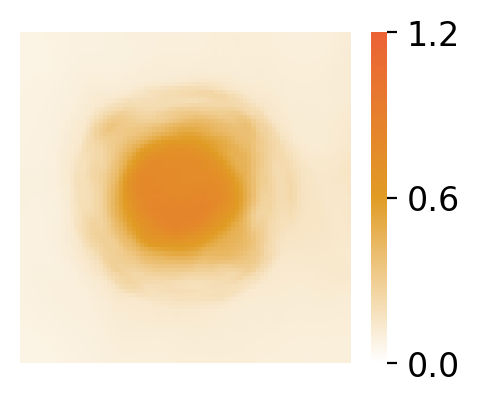

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

min_lim = 0. #np.min(uncertainty_map) 
max_lim = 1.2 #np.max(uncertainty_map) 
cbar_ticks = dict(ticks=[min_lim,
                     (min_lim+max_lim)/2,
                     max_lim]) 

sns.heatmap(object_crop,
            ax=ax,
            cbar=True,
            square=True,
            xticklabels=False,
            yticklabels=False,
            linewidths=0.0, rasterized=True,
            vmin=min_lim, vmax=max_lim,
            cmap = cmap,
            cbar_kws = cbar_ticks,
           cbar_ax = cax,)
cax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.tight_layout()

if save_fig:
    fig.savefig(os.path.join(fig_path, f"object_{chosen_object}_uncertainties_gnn{checkpoint_name}.pdf"), dpi=300)

# Compute per object interactions in the free play data:

In [56]:
with open(os.path.join(model_path, 'checkpoints_249/rollouts'), 'rb') as f:
    buffer = pickle.load(f)

In [57]:
def interaction_tracker(observations, next_observations, env):
    playground_boundary = env.playground_size - 0.2
    
    obs_state_dict = env.get_object_centric_obs(observations)
    obs_state_dict_next = env.get_object_centric_obs(next_observations)
    agent = obs_state_dict["agent"]
    objects_delta = obs_state_dict['objects_dyn'] - obs_state_dict_next['objects_dyn']
        
    object_moved_indices = np.any(np.abs(objects_delta[...,:3])>1e-3, axis=-1)

    cube_moved = np.sum(object_moved_indices[0,:])
    cube_light_moved = np.sum(object_moved_indices[1,:])
    cylinder_moved = np.sum(object_moved_indices[2,:])
    pyramid_moved = np.sum(object_moved_indices[3,:])

    
    factor_for_relative_scaling = observations.shape[0]

    rel_cube_time = cube_moved / factor_for_relative_scaling
    rel_cube_light_time = cube_light_moved / factor_for_relative_scaling
    rel_cylinder_time = cylinder_moved / factor_for_relative_scaling
    rel_pyramid_time = pyramid_moved / factor_for_relative_scaling
    
    return rel_cube_time, rel_cube_light_time, rel_cylinder_time, rel_pyramid_time

### Compute interactions from buffer:

In [58]:
all_observations = buffer["observations"]
all_next_observations = buffer["next_observations"]

obs_per_it = np.arange(0, len(all_observations), 200*10)
num_it = 249

rel_cube_times = []
rel_cube_light_times = []
rel_cylinder_times = []
rel_pyramid_times = []

for i in range(num_it):
    obs = all_observations[obs_per_it[i]:obs_per_it[i+1],:]
    next_obs = all_next_observations[obs_per_it[i]:obs_per_it[i+1],:]
    
    rel_cube_time, rel_cube_light_time, rel_cylinder_time, rel_pyramid_time = interaction_tracker(obs, next_obs, env)
    rel_cube_times.append(rel_cube_time)
    rel_cube_light_times.append(rel_cube_light_time)
    rel_cylinder_times.append(rel_cylinder_time)
    rel_pyramid_times.append(rel_pyramid_time)

### Apply filter:

In [59]:
from scipy.signal import savgol_filter
ws = 11
poly = 3
rel_cube_times_s = savgol_filter(rel_cube_times, ws, poly) 
rel_cube_light_times_s = savgol_filter(rel_cube_light_times, ws, poly)
rel_cylinder_times_s = savgol_filter(rel_cylinder_times, ws, poly)
rel_pyramid_times_s = savgol_filter(rel_pyramid_times, ws, poly)

In [60]:
def export_legend(legend, filename):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, bbox_inches=bbox)

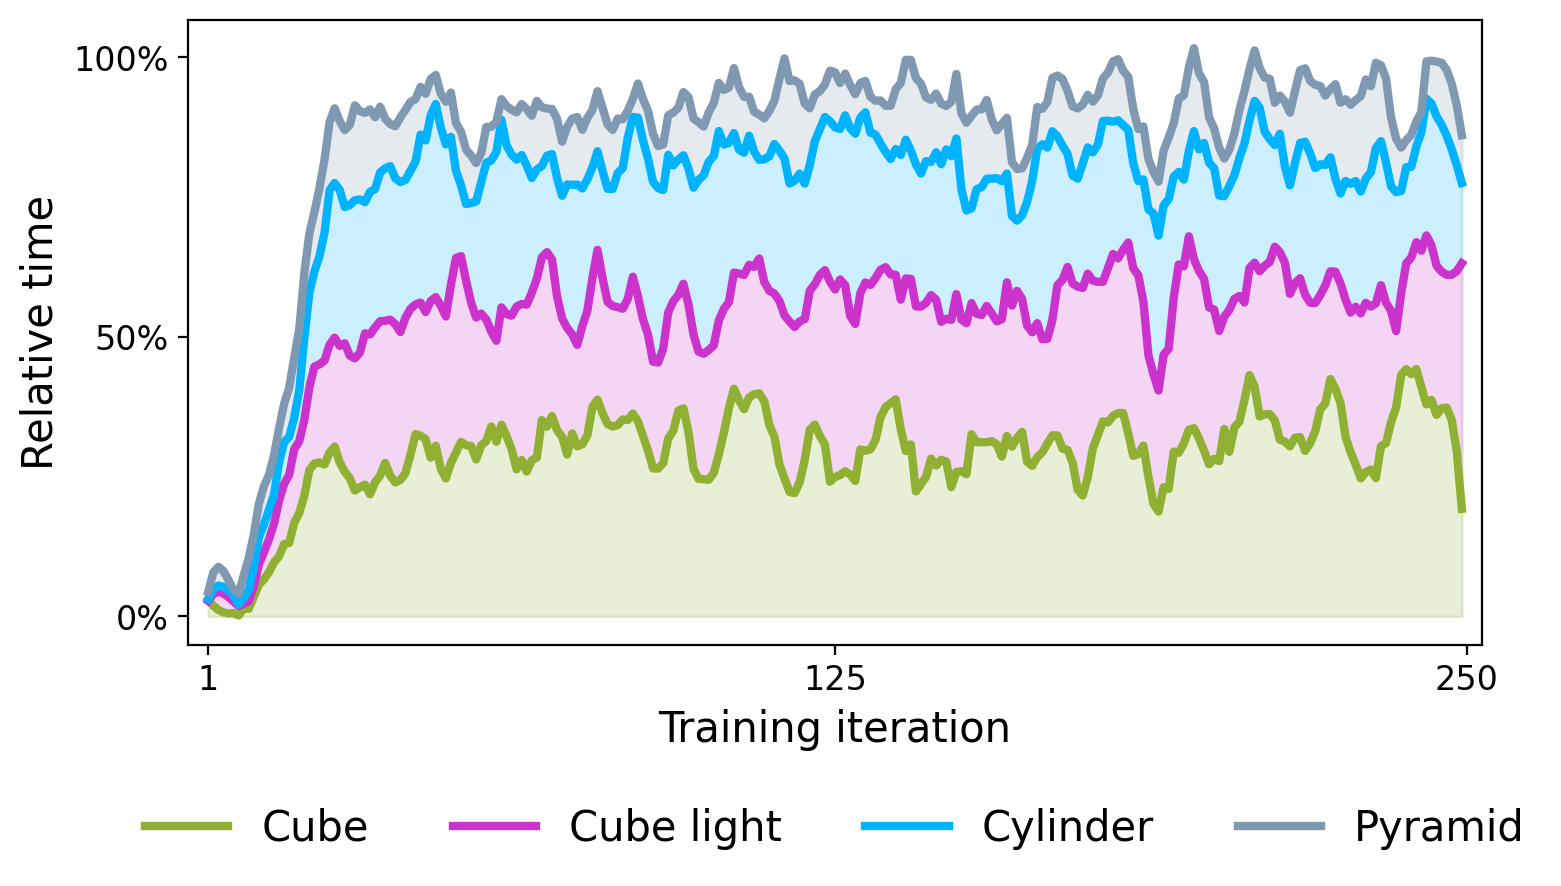

In [65]:
fig, ax = plt.subplots(1,1,figsize=(7.7,4.3))

t_lim = 249
rel_cube_times_s = rel_cube_times_s[:t_lim]
rel_cube_light_times_s = rel_cube_light_times_s[:t_lim]
rel_cylinder_times_s = rel_cylinder_times_s[:t_lim]
rel_pyramid_times_s = rel_pyramid_times_s[:t_lim]


x = np.arange(1,t_lim+1)
    
ax.plot(x,rel_cube_times_s, label="Cube", color=colors[3])
ax.fill_between(x, np.zeros_like(rel_cube_times_s), rel_cube_times_s, alpha = 0.2, color=colors[3])
accum_interaction = rel_cube_times_s.copy()

ax.plot(x,accum_interaction+rel_cube_light_times_s, label="Cube light", color=[0.8, 0.2, 0.8])
ax.fill_between(x, accum_interaction, accum_interaction+rel_cube_light_times_s, alpha = 0.2, color=[0.8, 0.2, 0.8])
accum_interaction += rel_cube_light_times_s


ax.plot(x,accum_interaction+rel_cylinder_times_s, label="Cylinder", color=[0.0, 0.7, 1.0])
ax.fill_between(x, accum_interaction, accum_interaction+rel_cylinder_times_s, alpha = 0.2, color=[0.0, 0.7, 1.0])
accum_interaction += rel_cylinder_times_s

ax.plot(x,accum_interaction+rel_pyramid_times_s, label="Pyramid", color=[0.5, 0.6, 0.7])
ax.fill_between(x, accum_interaction, accum_interaction+rel_pyramid_times_s, alpha = 0.2, color=[0.5, 0.6, 0.7])
accum_interaction += rel_pyramid_times_s

ax.set_xticks([1,125, 250])
ax.set_yticks([0., 0.5, 1.0])

ax.set_xlim([-3,t_lim+4])

vals = ax.get_yticks()

ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_ylabel("Relative time")
ax.set_xlabel("Training iteration")

fig.tight_layout()

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, shadow=False, ncol=4, frameon=False)

if save_fig:
    fig.savefig(os.path.join(fig_path, "interaction_plot_per_object_cee_us.png"),  dpi=300)